In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context("talk", font_scale=1.4)
import folium
from folium.plugins import HeatMap

In [2]:
news_coords = pd.read_csv('../tagnews/data/sexual-assault-2015-lat-longs.csv')
news_coords = news_coords[['lat', 'long']].values

In [3]:
# Download from
# https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2
crimes = pd.read_csv('../tagnews/data/Crimes_-_2001_to_present.csv')

In [4]:
crimes['Primary Type'].value_counts()

THEFT                                1378289
BATTERY                              1201725
CRIMINAL DAMAGE                       754510
NARCOTICS                             703262
OTHER OFFENSE                         408500
ASSAULT                               406027
BURGLARY                              380845
MOTOR VEHICLE THEFT                   308525
DECEPTIVE PRACTICE                    250743
ROBBERY                               250006
CRIMINAL TRESPASS                     189437
PROSTITUTION                           67851
WEAPONS VIOLATION                      67278
PUBLIC PEACE VIOLATION                 46956
OFFENSE INVOLVING CHILDREN             43908
CRIM SEXUAL ASSAULT                    25996
SEX OFFENSE                            24301
INTERFERENCE WITH PUBLIC OFFICER       14348
GAMBLING                               14245
LIQUOR LAW VIOLATION                   13880
ARSON                                  10919
HOMICIDE                                9043
KIDNAPPING

In [5]:
crimes.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [6]:
crimes = crimes.loc[(crimes['Primary Type'] == 'CRIM SEXUAL ASSAULT') | (crimes['Primary Type'] == 'SEX OFFENSE'), :]
times = pd.to_datetime(crimes['Date'])
crimes = crimes.loc[('2015' <= times) & (times <= '2016')]
# crime_coords = crimes[['Latitude', 'Longitude']]
# crime_coords = crime_coords.loc[~pd.isnull(crime_coords).any(axis=1)]
cavc = crimes['Community Area'].value_counts()
com_area = pd.DataFrame(np.array([cavc.index, cavc.values.flatten()]).T, columns=['area', 'count'])
com_area['area'] = com_area['area'].astype(int)
com_area['area'] = com_area['area'].astype(str)
com_area.set_index('area', drop=False, inplace=True)

In [7]:
import json
from collections import defaultdict
from shapely.geometry import shape, Point
# depending on your version, use: from shapely.geometry import shape, Point

# load GeoJSON file containing sectors
with open('com-areas.geojson') as f:
    js = json.load(f)

counts = defaultdict(lambda : 0)

for point in np.unique(news_coords, axis=0):
    point = Point([point[1], point[0]])
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            counts[feature['properties']['area_num_1']] += 1

In [8]:
com_area['actual_proportions'] = com_area['count'] / com_area['count'].sum()
com_area['news_counts'] = pd.Series(dict(counts))
com_area['news_counts'].fillna(0, inplace=True)
com_area['news_proportions'] = com_area['news_counts'] / com_area['news_counts'].sum()
com_area['news_minus_actual'] = com_area['news_proportions'] - com_area['actual_proportions']

In [18]:
m = folium.Map(location=[41.84871, -87.6298],
               zoom_start=11,
               tiles='cartodbpositron')

m.choropleth(geo_data='../tagnews/data/Boundaries - Community Areas (current).geojson',
             name='homicide',
             data=com_area,
             columns=['area', 'news_minus_actual'],
             key_on='feature.properties.area_num_1',
             threshold_scale=[-.1, -.02, .02, .1],
             fill_color='PRGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='News under reporting (-) vs. over reporting (+)')
folium.LayerControl().add_to(m)

m.save('sexual-assault-map.html')

In [31]:
m = folium.Map(location=[41.84871, -87.6298],
               zoom_start=11,
               tiles='cartodbpositron')

HeatMap(np.unique(news_coords, axis=0).tolist(),
        min_opacity=.2,
        max_val=.7).add_to(m)

m.save('sexual-assault-heatmap-map.html')

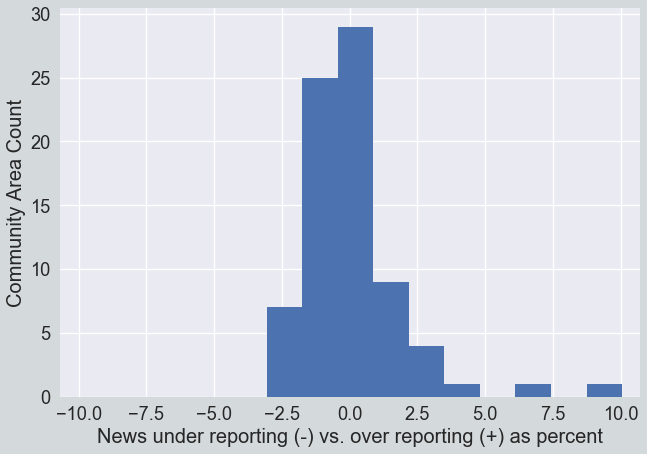

In [12]:
(com_area['news_minus_actual'] * 100).hist()
plt.xlim(np.array(max(abs(np.array(plt.gca().get_xlim())))) * [-1, 1])
plt.xlabel('News under reporting (-) vs. over reporting (+) as percent')
plt.ylabel('Community Area Count')
plt.gcf().set_facecolor(np.array([212, 218, 220]) / 255)
plt.show()

In [22]:
com_area

,area,count,actual_proportions,news_counts,news_proportions,news_minus_actual
area,,,,,,
25,25,143.0,0.060008,2.0,0.029851,-0.030158
8,8,75.0,0.031473,7.0,0.104478,0.073005
43,43,73.0,0.030634,0.0,0.000000,-0.030634
23,23,73.0,0.030634,2.0,0.029851,-0.000783
69,69,71.0,0.029794,1.0,0.014925,-0.014869
67,67,70.0,0.029375,0.0,0.000000,-0.029375
29,29,68.0,0.028535,1.0,0.014925,-0.013610
6,6,67.0,0.028116,2.0,0.029851,0.001735
28,28,65.0,0.027277,3.0,0.044776,0.017500
